# GAN example

In [1]:
# import necessary packages
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, UpSampling2D, Embedding, Concatenate

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [2]:
noise_dim = 100 

In [3]:
import cv2
import os
import numpy as np
def load_img(indir):
    samples = []
    labels = []
    for class_dir in os.listdir(indir):
        the_class = class_dir
        print(the_class)
        for file in os.listdir(indir+'/'+class_dir):
            if file.endswith('ppm'):
                image = cv2.imread("{}/{}/{}".format(indir,class_dir,file))
                image = cv2.resize(image, (64,64))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                #image = np.expand_dims(image,axis=2)
                samples.append(image)
                labels.append(the_class)
    samples = np.array(samples)
    labels = np.array(labels)
    return samples,labels

In [4]:
samples, labels = load_img('signs4')
print('loaded',len(samples),' samples')
print('classes',set(labels))
samples = samples/255
encoder = sklearn.preprocessing.LabelEncoder() # encoder
labels = encoder.fit_transform(labels)
print(labels[:10])

00001
00007
00014
00016
loaded 3300  samples
classes {'00001', '00014', '00016', '00007'}
[0 0 0 0 0 0 0 0 0 0]


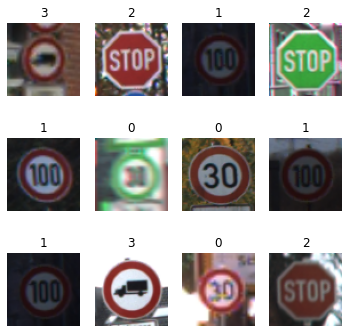

In [5]:
import random
plt.figure(figsize=(6, 6))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    r = random.randint(0,samples.shape[0])
    plt.imshow(samples[r][:,:,:])
    plt.title(labels[r])
    plt.axis("off")

In [6]:
# Generator gets a noise vector of size noise_dim and and class id (0,1,2,3)
# then generates an image of size (64 x 64 x 3) 
# Our aim: we want the image to be as similar to real images (generated above) as possible
def make_generator_model():
    
    
    input_layer = tf.keras.layers.Input(shape=(noise_dim,))
    x = Dense(8*8*64, use_bias=False)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((8, 8, 64))(x)

    input_label = tf.keras.layers.Input(shape=(1,))
    # embedding for categorical input
    y = Embedding(4, 50)(input_label)
    # scale up to image dimensions with linear activation
    y = Dense(8*8)(y)
    y = Reshape((8, 8, 1))(y)
    
    merged = Concatenate()([x, y])
    
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False)(merged)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    # output: 8 x 8 x 128

    x = UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
                    
    # output: 16 x 16 x 64

    x = UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    # output: 32 x 32 x 32

    x = UpSampling2D(size=(2, 2), data_format=None, interpolation="nearest")(x)
    output_layer = Conv2D(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid')(x)
    # output: 64 x 64 x 3
    model = tf.keras.models.Model(inputs=[input_layer,input_label], outputs=output_layer)
    model.summary()
    return model



generator = make_generator_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 4096)         409600      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 4096)         16384       dense[0][0]                      
______________________________________________________________________________________________

In [7]:
# Discriminator gets image of size (64 x 64 x 3) and class id (0,1,2,3)
# and decides if it is real or fake
# The result of the discriminator is used by generator to improve 'faking'

def make_discriminator_model():

    input_label = tf.keras.layers.Input(shape=(1,))
    # embedding for categorical input
    y = Embedding(4, 50)(input_label)
    # scale up to image dimensions with linear activation
    y = Dense(64*64*1)(y)
    y = Reshape((64, 64, 1))(y)
     
    input_layer = tf.keras.layers.Input(shape=(64, 64, 3))
    
    merged = Concatenate()([input_layer, y])
    x = Conv2D(64, (8, 8), strides=(2, 2), padding='same', input_shape=[64, 64, 4])(merged)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (8, 8), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    output_layer = Dense(1,activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=[input_layer,input_label], outputs=output_layer)
    model.summary()

    return model

discriminator = make_discriminator_model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        200         input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1, 4096)      208896      embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
____________________________________________________________________________________________

In [8]:
# returns randomly choosen n real samples

def sample_from_dataset(n,samples):
    prev_numbers = []
    new_samples = []
    new_labels = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
        new_labels.append(labels[number])
    new_samples = np.array(new_samples,dtype=float)    
    new_labels = np.array(new_labels)    
    return new_samples,new_labels

In [9]:
# training parameters
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)
cross_entropy = tf.keras.losses.BinaryCrossentropy()


In [10]:
from numpy.random import randn

def calc_ok(vct):
    ok = 0
    for x in vct: 
        if x>=0.5: 
            ok+=1 
    return ok

# The training step

history = []
##@tf.function
def do_step(images, labels):
    batch_size = len(images)
    images = np.array(images)
    labels = np.expand_dims(labels,axis=1)
    # create random noise for generator
    input_noise = randn(batch_size * noise_dim)
    input_noise = input_noise.reshape(batch_size, noise_dim)
    input_noise = tf.convert_to_tensor(input_noise)

    random_labels = np.random.randint(4, size=batch_size)
    random_labels = np.expand_dims(random_labels,axis=1)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # generate fake image using noise
        generated_images = generator([input_noise,random_labels], training=True)
        # evaluate fake images
        fake_output = discriminator([generated_images,random_labels], training=True)
        fake_acc = (batch_size-calc_ok(fake_output))/batch_size
        # generator want all images to be accepted (output=1)!
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
        # evaluate real images
        real_output = discriminator([images,labels], training=True)
        real_acc = calc_ok(real_output)/batch_size
        # discriminator wants to classify all real images as 1 and fake images as 0
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = (real_loss + fake_loss)/2 # sum up both losses

    # calculate how to change generator to minimze its loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) # step 4. calculate the gradient of the losses
    # calculate how to change discriminator to minimze its loss
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # update weights for both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # step 5. Apply the optimizers and update weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    if epoch % 100 == 0:
        print("Epoch",epoch,'g_loss=',gen_loss.numpy(),'d_loss=',disc_loss.numpy(),"real_acc=",real_acc,"fake_acc=",fake_acc)
    history.append([gen_loss.numpy(),disc_loss.numpy(),real_acc,fake_acc])
    

Epoch 0 g_loss= 0.73983794 d_loss= 0.68703854 real_acc= 0.16 fake_acc= 0.78


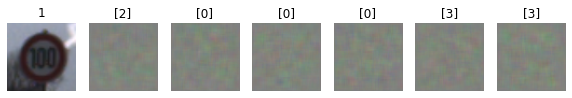

Epoch 100 g_loss= 0.9317123 d_loss= 0.61913204 real_acc= 0.54 fake_acc= 0.98
Epoch 200 g_loss= 1.1042678 d_loss= 0.55244637 real_acc= 0.68 fake_acc= 1.0
Epoch 300 g_loss= 1.2630763 d_loss= 0.5189408 real_acc= 0.66 fake_acc= 1.0
Epoch 400 g_loss= 1.2344618 d_loss= 0.4813638 real_acc= 0.76 fake_acc= 0.94
Epoch 500 g_loss= 1.2236222 d_loss= 0.41391575 real_acc= 0.82 fake_acc= 0.92


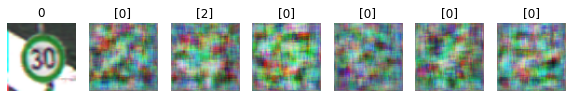

Epoch 600 g_loss= 1.1065876 d_loss= 0.4863499 real_acc= 0.74 fake_acc= 0.82
Epoch 700 g_loss= 1.4658148 d_loss= 0.44073933 real_acc= 0.78 fake_acc= 1.0
Epoch 800 g_loss= 1.1686542 d_loss= 0.45075786 real_acc= 0.84 fake_acc= 0.92
Epoch 900 g_loss= 1.2999241 d_loss= 0.4315741 real_acc= 0.76 fake_acc= 0.98
Epoch 1000 g_loss= 1.4696296 d_loss= 0.31993353 real_acc= 0.9 fake_acc= 0.98


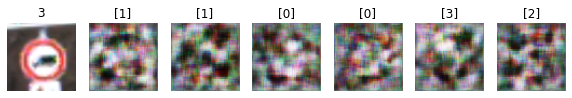

Epoch 1100 g_loss= 1.5833561 d_loss= 0.2749313 real_acc= 0.92 fake_acc= 1.0
Epoch 1200 g_loss= 1.6997195 d_loss= 0.27978644 real_acc= 0.9 fake_acc= 1.0
Epoch 1300 g_loss= 1.7018409 d_loss= 0.2731465 real_acc= 0.9 fake_acc= 1.0
Epoch 1400 g_loss= 1.7793548 d_loss= 0.34150693 real_acc= 0.76 fake_acc= 0.98
Epoch 1500 g_loss= 1.671785 d_loss= 0.29894584 real_acc= 0.92 fake_acc= 1.0


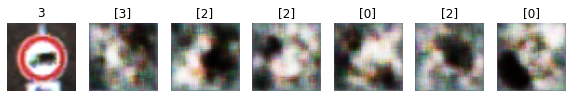

Epoch 1600 g_loss= 1.4449633 d_loss= 0.3165772 real_acc= 0.92 fake_acc= 0.96
Epoch 1700 g_loss= 1.6997987 d_loss= 0.3805013 real_acc= 0.82 fake_acc= 0.96
Epoch 1800 g_loss= 1.4813182 d_loss= 0.40420705 real_acc= 0.78 fake_acc= 0.86
Epoch 1900 g_loss= 1.2911185 d_loss= 0.35819948 real_acc= 0.88 fake_acc= 0.88
Epoch 2000 g_loss= 1.2859275 d_loss= 0.46782413 real_acc= 0.72 fake_acc= 0.82


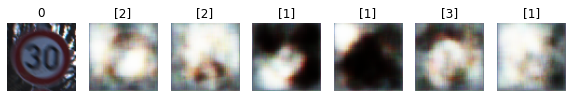

Epoch 2100 g_loss= 1.576511 d_loss= 0.33920652 real_acc= 0.84 fake_acc= 0.92
Epoch 2200 g_loss= 1.545893 d_loss= 0.4465879 real_acc= 0.74 fake_acc= 0.92
Epoch 2300 g_loss= 1.2719417 d_loss= 0.39003196 real_acc= 0.86 fake_acc= 0.86
Epoch 2400 g_loss= 1.4697919 d_loss= 0.30443817 real_acc= 0.92 fake_acc= 0.96
Epoch 2500 g_loss= 1.349588 d_loss= 0.37744182 real_acc= 0.88 fake_acc= 0.86


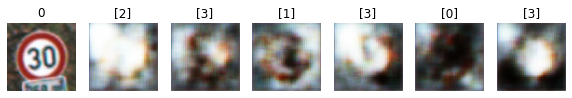

Epoch 2600 g_loss= 1.5532593 d_loss= 0.32513905 real_acc= 0.88 fake_acc= 0.92
Epoch 2700 g_loss= 1.1654506 d_loss= 0.37692344 real_acc= 0.88 fake_acc= 0.78
Epoch 2800 g_loss= 1.2815648 d_loss= 0.31800315 real_acc= 0.98 fake_acc= 0.94
Epoch 2900 g_loss= 1.3400449 d_loss= 0.31139818 real_acc= 0.94 fake_acc= 0.9
Epoch 3000 g_loss= 1.2192658 d_loss= 0.34689564 real_acc= 0.92 fake_acc= 0.82


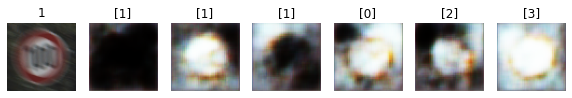

Epoch 3100 g_loss= 1.7472754 d_loss= 0.39598045 real_acc= 0.72 fake_acc= 0.98
Epoch 3200 g_loss= 1.292728 d_loss= 0.35705417 real_acc= 0.88 fake_acc= 0.9
Epoch 3300 g_loss= 1.6155618 d_loss= 0.3264569 real_acc= 0.86 fake_acc= 0.98
Epoch 3400 g_loss= 1.2753687 d_loss= 0.42705473 real_acc= 0.86 fake_acc= 0.86
Epoch 3500 g_loss= 1.4279715 d_loss= 0.3226766 real_acc= 0.88 fake_acc= 0.94


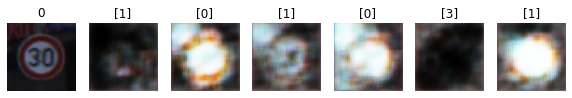

Epoch 3600 g_loss= 1.7751468 d_loss= 0.29274943 real_acc= 0.86 fake_acc= 0.98
Epoch 3700 g_loss= 1.6768129 d_loss= 0.350976 real_acc= 0.84 fake_acc= 0.98
Epoch 3800 g_loss= 1.587524 d_loss= 0.33489153 real_acc= 0.84 fake_acc= 0.98
Epoch 3900 g_loss= 1.2826791 d_loss= 0.34413385 real_acc= 0.94 fake_acc= 0.84
Epoch 4000 g_loss= 1.7773815 d_loss= 0.37275726 real_acc= 0.88 fake_acc= 0.98


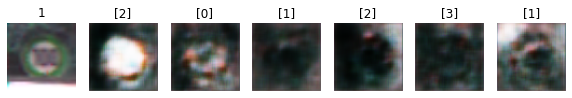

Epoch 4100 g_loss= 1.5485017 d_loss= 0.4343636 real_acc= 0.72 fake_acc= 0.98
Epoch 4200 g_loss= 1.6611149 d_loss= 0.30176607 real_acc= 0.86 fake_acc= 0.96
Epoch 4300 g_loss= 1.1523547 d_loss= 0.3684919 real_acc= 0.96 fake_acc= 0.72
Epoch 4400 g_loss= 1.233661 d_loss= 0.3483063 real_acc= 0.92 fake_acc= 0.84
Epoch 4500 g_loss= 1.7075648 d_loss= 0.3577395 real_acc= 0.74 fake_acc= 0.98


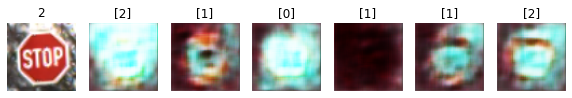

Epoch 4600 g_loss= 1.6911306 d_loss= 0.3287144 real_acc= 0.82 fake_acc= 0.94
Epoch 4700 g_loss= 1.7530799 d_loss= 0.31252077 real_acc= 0.82 fake_acc= 0.92
Epoch 4800 g_loss= 1.4933678 d_loss= 0.35234752 real_acc= 0.88 fake_acc= 0.9
Epoch 4900 g_loss= 1.8587241 d_loss= 0.33890438 real_acc= 0.82 fake_acc= 0.98
Epoch 5000 g_loss= 1.6241693 d_loss= 0.41835696 real_acc= 0.72 fake_acc= 1.0


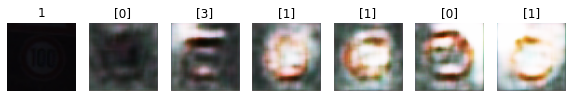

Epoch 5100 g_loss= 1.5010892 d_loss= 0.36041608 real_acc= 0.78 fake_acc= 0.94
Epoch 5200 g_loss= 1.5477237 d_loss= 0.34899926 real_acc= 0.88 fake_acc= 0.94
Epoch 5300 g_loss= 1.1373165 d_loss= 0.3792258 real_acc= 0.92 fake_acc= 0.82
Epoch 5400 g_loss= 1.2633622 d_loss= 0.37199095 real_acc= 0.9 fake_acc= 0.88
Epoch 5500 g_loss= 1.5781773 d_loss= 0.33867878 real_acc= 0.86 fake_acc= 0.94


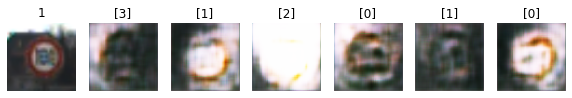

Epoch 5600 g_loss= 1.7633536 d_loss= 0.3359891 real_acc= 0.9 fake_acc= 0.92
Epoch 5700 g_loss= 1.5210693 d_loss= 0.34332746 real_acc= 0.84 fake_acc= 0.94
Epoch 5800 g_loss= 1.484472 d_loss= 0.3217497 real_acc= 0.88 fake_acc= 0.94
Epoch 5900 g_loss= 1.962457 d_loss= 0.27534118 real_acc= 0.88 fake_acc= 1.0
Epoch 6000 g_loss= 1.5150247 d_loss= 0.37480533 real_acc= 0.84 fake_acc= 0.96


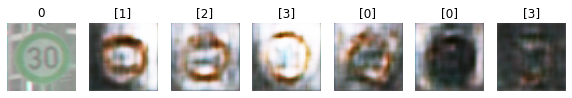

Epoch 6100 g_loss= 1.4903418 d_loss= 0.35339093 real_acc= 0.9 fake_acc= 0.88
Epoch 6200 g_loss= 1.8052869 d_loss= 0.31879205 real_acc= 0.84 fake_acc= 1.0
Epoch 6300 g_loss= 1.4275833 d_loss= 0.4064294 real_acc= 0.76 fake_acc= 0.9
Epoch 6400 g_loss= 1.3431022 d_loss= 0.38124242 real_acc= 0.9 fake_acc= 0.9
Epoch 6500 g_loss= 1.4357721 d_loss= 0.3519886 real_acc= 0.92 fake_acc= 0.88


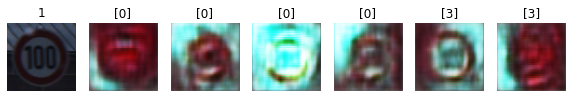

Epoch 6600 g_loss= 1.7313964 d_loss= 0.24143723 real_acc= 0.94 fake_acc= 0.92
Epoch 6700 g_loss= 2.0092819 d_loss= 0.2978433 real_acc= 0.8 fake_acc= 0.98
Epoch 6800 g_loss= 1.5686237 d_loss= 0.3335988 real_acc= 0.92 fake_acc= 0.94
Epoch 6900 g_loss= 1.1611215 d_loss= 0.3751055 real_acc= 0.9 fake_acc= 0.74
Epoch 7000 g_loss= 1.4892906 d_loss= 0.33183974 real_acc= 0.84 fake_acc= 0.9


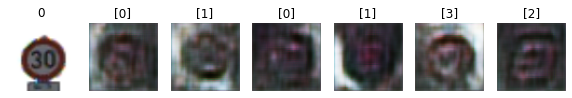

Epoch 7100 g_loss= 1.723442 d_loss= 0.34962887 real_acc= 0.86 fake_acc= 0.98
Epoch 7200 g_loss= 1.709505 d_loss= 0.26198882 real_acc= 0.98 fake_acc= 0.94
Epoch 7300 g_loss= 1.7568845 d_loss= 0.3728776 real_acc= 0.72 fake_acc= 0.96
Epoch 7400 g_loss= 1.4985179 d_loss= 0.3411252 real_acc= 0.88 fake_acc= 0.94
Epoch 7500 g_loss= 1.4145465 d_loss= 0.3470872 real_acc= 0.9 fake_acc= 0.92


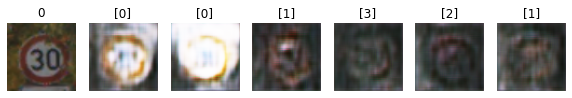

Epoch 7600 g_loss= 1.2458771 d_loss= 0.35745388 real_acc= 0.94 fake_acc= 0.82
Epoch 7700 g_loss= 1.3632911 d_loss= 0.36734298 real_acc= 0.86 fake_acc= 0.8
Epoch 7800 g_loss= 1.664357 d_loss= 0.2675403 real_acc= 0.94 fake_acc= 0.92
Epoch 7900 g_loss= 1.4591109 d_loss= 0.33836922 real_acc= 0.92 fake_acc= 0.86
Epoch 8000 g_loss= 1.7511683 d_loss= 0.29422173 real_acc= 0.92 fake_acc= 0.96


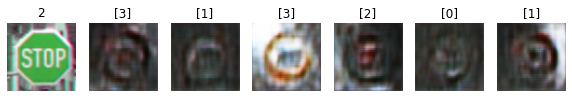

Epoch 8100 g_loss= 1.4598138 d_loss= 0.3732142 real_acc= 0.88 fake_acc= 0.88
Epoch 8200 g_loss= 1.8165271 d_loss= 0.34232828 real_acc= 0.76 fake_acc= 0.98
Epoch 8300 g_loss= 1.7188942 d_loss= 0.26817828 real_acc= 0.86 fake_acc= 1.0
Epoch 8400 g_loss= 2.055163 d_loss= 0.37431395 real_acc= 0.76 fake_acc= 0.98
Epoch 8500 g_loss= 1.7554501 d_loss= 0.27847487 real_acc= 0.9 fake_acc= 0.96


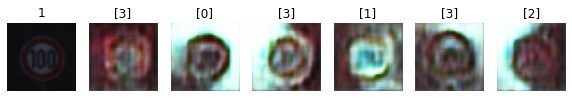

Epoch 8600 g_loss= 1.706785 d_loss= 0.33397514 real_acc= 0.84 fake_acc= 0.96
Epoch 8700 g_loss= 1.5897727 d_loss= 0.30806917 real_acc= 0.88 fake_acc= 0.96
Epoch 8800 g_loss= 1.7440286 d_loss= 0.2950845 real_acc= 0.88 fake_acc= 0.94
Epoch 8900 g_loss= 1.3762702 d_loss= 0.33157924 real_acc= 0.94 fake_acc= 0.84
Epoch 9000 g_loss= 2.0499585 d_loss= 0.28123122 real_acc= 0.88 fake_acc= 0.98


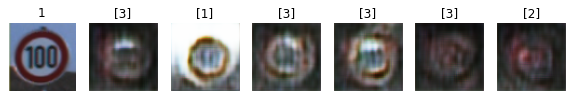

Epoch 9100 g_loss= 1.8903202 d_loss= 0.32486904 real_acc= 0.84 fake_acc= 0.92
Epoch 9200 g_loss= 1.7251058 d_loss= 0.2479806 real_acc= 0.96 fake_acc= 0.94
Epoch 9300 g_loss= 1.7372133 d_loss= 0.24936095 real_acc= 0.96 fake_acc= 0.92
Epoch 9400 g_loss= 2.1208413 d_loss= 0.27435946 real_acc= 0.84 fake_acc= 0.98
Epoch 9500 g_loss= 1.7182634 d_loss= 0.29753965 real_acc= 0.88 fake_acc= 1.0


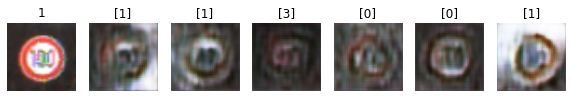

Epoch 9600 g_loss= 1.5871723 d_loss= 0.2854876 real_acc= 0.9 fake_acc= 0.94
Epoch 9700 g_loss= 1.576406 d_loss= 0.32241976 real_acc= 0.86 fake_acc= 0.9
Epoch 9800 g_loss= 1.5933564 d_loss= 0.34157538 real_acc= 0.84 fake_acc= 0.84
Epoch 9900 g_loss= 2.1313696 d_loss= 0.26165143 real_acc= 0.88 fake_acc= 0.96
Epoch 10000 g_loss= 1.9558672 d_loss= 0.25766456 real_acc= 0.92 fake_acc= 0.94


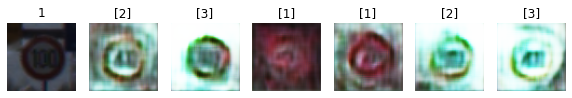

Epoch 10100 g_loss= 1.6684848 d_loss= 0.29026622 real_acc= 0.9 fake_acc= 0.96
Epoch 10200 g_loss= 1.7585094 d_loss= 0.27499846 real_acc= 0.88 fake_acc= 0.96
Epoch 10300 g_loss= 1.9347359 d_loss= 0.24753487 real_acc= 0.88 fake_acc= 1.0
Epoch 10400 g_loss= 1.9248054 d_loss= 0.31010765 real_acc= 0.82 fake_acc= 0.98
Epoch 10500 g_loss= 1.559797 d_loss= 0.2917438 real_acc= 1.0 fake_acc= 0.86


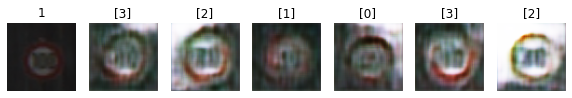

Epoch 10600 g_loss= 2.092919 d_loss= 0.27977636 real_acc= 0.82 fake_acc= 1.0
Epoch 10700 g_loss= 1.685611 d_loss= 0.2997756 real_acc= 0.92 fake_acc= 0.88
Epoch 10800 g_loss= 1.537014 d_loss= 0.32667932 real_acc= 0.92 fake_acc= 0.78
Epoch 10900 g_loss= 2.3590248 d_loss= 0.2659539 real_acc= 0.9 fake_acc= 0.96
Epoch 11000 g_loss= 1.6458709 d_loss= 0.3212068 real_acc= 0.9 fake_acc= 0.82


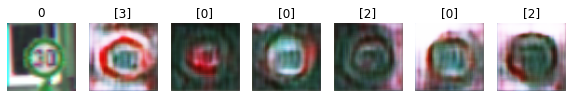

Epoch 11100 g_loss= 1.8978986 d_loss= 0.23695609 real_acc= 0.96 fake_acc= 0.92
Epoch 11200 g_loss= 2.2223923 d_loss= 0.22323075 real_acc= 0.9 fake_acc= 0.98
Epoch 11300 g_loss= 1.5342016 d_loss= 0.31954518 real_acc= 0.94 fake_acc= 0.82
Epoch 11400 g_loss= 1.760623 d_loss= 0.2754926 real_acc= 0.94 fake_acc= 0.86
Epoch 11500 g_loss= 1.9282141 d_loss= 0.23735908 real_acc= 0.98 fake_acc= 0.88


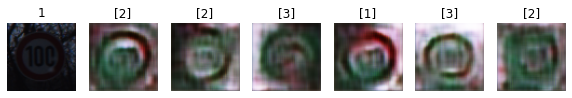

Epoch 11600 g_loss= 1.8451226 d_loss= 0.32738978 real_acc= 0.84 fake_acc= 0.9
Epoch 11700 g_loss= 2.3383613 d_loss= 0.23789793 real_acc= 0.88 fake_acc= 0.96
Epoch 11800 g_loss= 1.4803994 d_loss= 0.3176102 real_acc= 0.94 fake_acc= 0.72
Epoch 11900 g_loss= 2.4662855 d_loss= 0.27026877 real_acc= 0.86 fake_acc= 0.96
Epoch 12000 g_loss= 1.6293924 d_loss= 0.30003595 real_acc= 0.9 fake_acc= 0.86


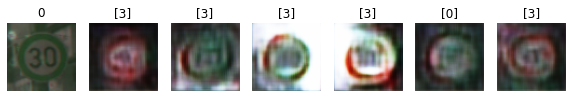

Epoch 12100 g_loss= 1.7905128 d_loss= 0.29689297 real_acc= 0.86 fake_acc= 0.86
Epoch 12200 g_loss= 2.005966 d_loss= 0.24413934 real_acc= 0.94 fake_acc= 0.94
Epoch 12300 g_loss= 2.422262 d_loss= 0.26413488 real_acc= 0.84 fake_acc= 0.94
Epoch 12400 g_loss= 2.51664 d_loss= 0.2411382 real_acc= 0.88 fake_acc= 0.94
Epoch 12500 g_loss= 2.3328934 d_loss= 0.29823452 real_acc= 0.86 fake_acc= 0.94


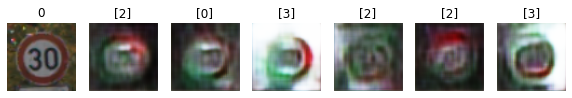

Epoch 12600 g_loss= 2.5996292 d_loss= 0.17213371 real_acc= 0.96 fake_acc= 0.96
Epoch 12700 g_loss= 2.6254926 d_loss= 0.25295234 real_acc= 0.88 fake_acc= 0.98
Epoch 12800 g_loss= 2.2340338 d_loss= 0.3202356 real_acc= 0.82 fake_acc= 0.96
Epoch 12900 g_loss= 2.6124585 d_loss= 0.2589242 real_acc= 0.84 fake_acc= 1.0
Epoch 13000 g_loss= 1.8116958 d_loss= 0.24518329 real_acc= 0.92 fake_acc= 0.94


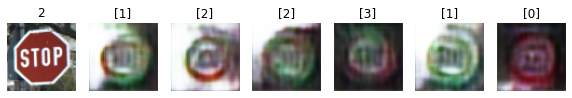

Epoch 13100 g_loss= 2.5830863 d_loss= 0.22252108 real_acc= 0.88 fake_acc= 0.98
Epoch 13200 g_loss= 2.2322967 d_loss= 0.2726869 real_acc= 0.9 fake_acc= 0.92
Epoch 13300 g_loss= 2.1997669 d_loss= 0.20769916 real_acc= 0.96 fake_acc= 0.94
Epoch 13400 g_loss= 1.9883267 d_loss= 0.25594974 real_acc= 0.92 fake_acc= 0.96
Epoch 13500 g_loss= 1.7478834 d_loss= 0.23552135 real_acc= 0.96 fake_acc= 0.9


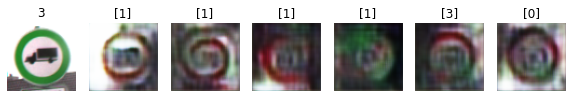

Epoch 13600 g_loss= 2.366795 d_loss= 0.2506824 real_acc= 0.9 fake_acc= 0.94
Epoch 13700 g_loss= 2.3492212 d_loss= 0.19954684 real_acc= 0.96 fake_acc= 0.9
Epoch 13800 g_loss= 2.090891 d_loss= 0.2815592 real_acc= 0.9 fake_acc= 0.86
Epoch 13900 g_loss= 2.2107062 d_loss= 0.26829994 real_acc= 0.9 fake_acc= 0.92
Epoch 14000 g_loss= 2.4379914 d_loss= 0.19352546 real_acc= 0.94 fake_acc= 0.98


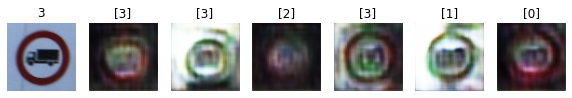

Epoch 14100 g_loss= 1.9861734 d_loss= 0.21252266 real_acc= 1.0 fake_acc= 0.88
Epoch 14200 g_loss= 2.9105952 d_loss= 0.25575724 real_acc= 0.88 fake_acc= 0.9
Epoch 14300 g_loss= 2.1038332 d_loss= 0.2633745 real_acc= 0.98 fake_acc= 0.8
Epoch 14400 g_loss= 1.9836175 d_loss= 0.25640458 real_acc= 0.92 fake_acc= 0.92
Epoch 14500 g_loss= 2.1609206 d_loss= 0.21592872 real_acc= 0.92 fake_acc= 0.96


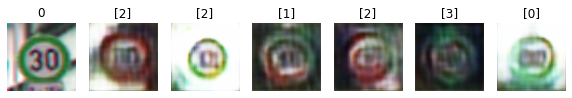

Epoch 14600 g_loss= 2.1840591 d_loss= 0.23310597 real_acc= 0.98 fake_acc= 0.88
Epoch 14700 g_loss= 2.5610645 d_loss= 0.3244878 real_acc= 0.8 fake_acc= 0.96
Epoch 14800 g_loss= 2.1084003 d_loss= 0.2456485 real_acc= 0.94 fake_acc= 0.9
Epoch 14900 g_loss= 2.0150902 d_loss= 0.21535936 real_acc= 0.98 fake_acc= 0.98
Epoch 15000 g_loss= 2.0441372 d_loss= 0.21821685 real_acc= 0.96 fake_acc= 0.98


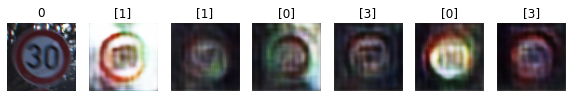

Epoch 15100 g_loss= 2.143193 d_loss= 0.26060942 real_acc= 0.9 fake_acc= 0.88
Epoch 15200 g_loss= 2.3532865 d_loss= 0.1818489 real_acc= 0.94 fake_acc= 1.0
Epoch 15300 g_loss= 1.8235483 d_loss= 0.24326989 real_acc= 0.94 fake_acc= 0.86
Epoch 15400 g_loss= 2.3713732 d_loss= 0.23327298 real_acc= 0.94 fake_acc= 0.9
Epoch 15500 g_loss= 2.193435 d_loss= 0.2451225 real_acc= 0.92 fake_acc= 0.9


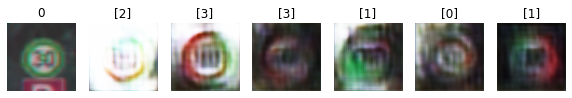

Epoch 15600 g_loss= 2.6055305 d_loss= 0.17385215 real_acc= 0.94 fake_acc= 0.98
Epoch 15700 g_loss= 2.1778774 d_loss= 0.2584538 real_acc= 0.9 fake_acc= 0.9
Epoch 15800 g_loss= 1.9688814 d_loss= 0.22085343 real_acc= 0.96 fake_acc= 0.9
Epoch 15900 g_loss= 2.3332877 d_loss= 0.18923509 real_acc= 0.96 fake_acc= 0.98
Epoch 16000 g_loss= 2.380896 d_loss= 0.23460746 real_acc= 0.88 fake_acc= 0.96


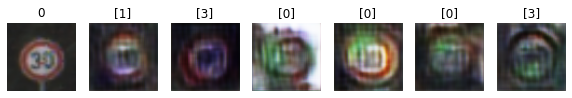

Epoch 16100 g_loss= 2.0496686 d_loss= 0.25256425 real_acc= 0.88 fake_acc= 0.94
Epoch 16200 g_loss= 2.2304444 d_loss= 0.27187783 real_acc= 0.84 fake_acc= 0.98
Epoch 16300 g_loss= 1.8276858 d_loss= 0.29509404 real_acc= 0.92 fake_acc= 0.86
Epoch 16400 g_loss= 2.2020347 d_loss= 0.23089656 real_acc= 0.9 fake_acc= 0.94
Epoch 16500 g_loss= 2.0327883 d_loss= 0.1688296 real_acc= 0.98 fake_acc= 0.96


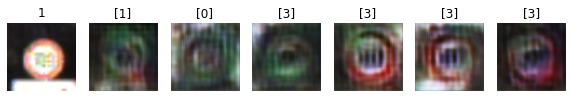

Epoch 16600 g_loss= 2.1838636 d_loss= 0.22301902 real_acc= 0.98 fake_acc= 0.92
Epoch 16700 g_loss= 2.206055 d_loss= 0.25191197 real_acc= 0.9 fake_acc= 0.94
Epoch 16800 g_loss= 1.6729116 d_loss= 0.28495365 real_acc= 0.92 fake_acc= 0.82
Epoch 16900 g_loss= 2.471984 d_loss= 0.20501792 real_acc= 0.88 fake_acc= 1.0
Epoch 17000 g_loss= 2.2099752 d_loss= 0.21686164 real_acc= 0.92 fake_acc= 0.92


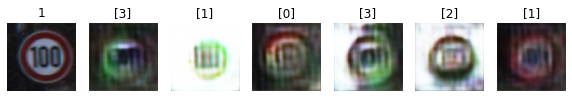

Epoch 17100 g_loss= 2.2828004 d_loss= 0.21301591 real_acc= 0.94 fake_acc= 0.96
Epoch 17200 g_loss= 2.5908866 d_loss= 0.21007691 real_acc= 0.94 fake_acc= 1.0
Epoch 17300 g_loss= 2.282204 d_loss= 0.22205931 real_acc= 0.88 fake_acc= 1.0
Epoch 17400 g_loss= 3.035952 d_loss= 0.27637494 real_acc= 0.78 fake_acc= 1.0
Epoch 17500 g_loss= 2.2668421 d_loss= 0.20813489 real_acc= 0.96 fake_acc= 0.98


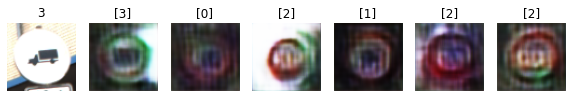

Epoch 17600 g_loss= 2.6014524 d_loss= 0.23470774 real_acc= 0.88 fake_acc= 0.98
Epoch 17700 g_loss= 2.292865 d_loss= 0.21565218 real_acc= 0.9 fake_acc= 0.96
Epoch 17800 g_loss= 2.5636556 d_loss= 0.22642742 real_acc= 0.92 fake_acc= 0.94
Epoch 17900 g_loss= 2.8877923 d_loss= 0.252524 real_acc= 0.78 fake_acc= 1.0
Epoch 18000 g_loss= 2.3581085 d_loss= 0.1726925 real_acc= 0.96 fake_acc= 0.98


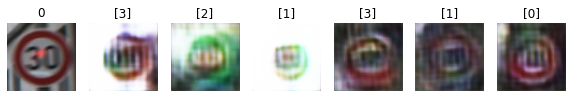

Epoch 18100 g_loss= 2.3390713 d_loss= 0.25510773 real_acc= 0.88 fake_acc= 0.92
Epoch 18200 g_loss= 2.041799 d_loss= 0.23380905 real_acc= 0.94 fake_acc= 0.92
Epoch 18300 g_loss= 2.7433581 d_loss= 0.19385819 real_acc= 0.9 fake_acc= 0.96
Epoch 18400 g_loss= 2.0943356 d_loss= 0.23393366 real_acc= 0.98 fake_acc= 0.86
Epoch 18500 g_loss= 2.1359777 d_loss= 0.1903097 real_acc= 0.98 fake_acc= 0.94


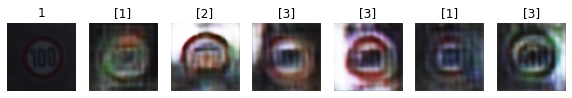

Epoch 18600 g_loss= 2.4128306 d_loss= 0.17394482 real_acc= 0.94 fake_acc= 1.0
Epoch 18700 g_loss= 2.6631837 d_loss= 0.1787985 real_acc= 0.92 fake_acc= 1.0
Epoch 18800 g_loss= 2.3340828 d_loss= 0.17633553 real_acc= 0.94 fake_acc= 0.98
Epoch 18900 g_loss= 2.1263034 d_loss= 0.17906432 real_acc= 1.0 fake_acc= 0.92
Epoch 19000 g_loss= 2.377854 d_loss= 0.21823758 real_acc= 0.94 fake_acc= 0.98


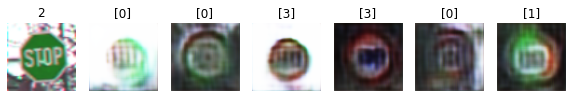

Epoch 19100 g_loss= 2.566015 d_loss= 0.18577412 real_acc= 0.92 fake_acc= 0.98
Epoch 19200 g_loss= 1.8022684 d_loss= 0.203675 real_acc= 0.98 fake_acc= 0.86
Epoch 19300 g_loss= 1.9656583 d_loss= 0.19661555 real_acc= 0.98 fake_acc= 0.92
Epoch 19400 g_loss= 2.6072729 d_loss= 0.19730076 real_acc= 0.88 fake_acc= 0.98
Epoch 19500 g_loss= 2.1646454 d_loss= 0.18508448 real_acc= 0.96 fake_acc= 0.94


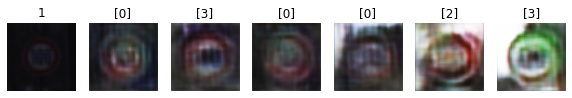

Epoch 19600 g_loss= 2.0886436 d_loss= 0.22696376 real_acc= 0.92 fake_acc= 1.0
Epoch 19700 g_loss= 2.4669247 d_loss= 0.16848499 real_acc= 0.98 fake_acc= 0.96
Epoch 19800 g_loss= 2.7169855 d_loss= 0.19002318 real_acc= 0.9 fake_acc= 0.96
Epoch 19900 g_loss= 2.4930685 d_loss= 0.21172214 real_acc= 0.88 fake_acc= 0.98
Epoch 20000 g_loss= 2.4899285 d_loss= 0.22838551 real_acc= 0.86 fake_acc= 1.0


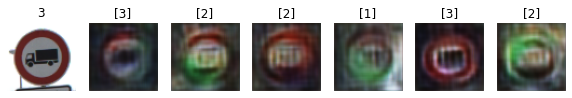

Epoch 20100 g_loss= 1.9282179 d_loss= 0.20737705 real_acc= 0.96 fake_acc= 0.9
Epoch 20200 g_loss= 1.989776 d_loss= 0.17466234 real_acc= 0.98 fake_acc= 0.96
Epoch 20300 g_loss= 2.5920641 d_loss= 0.21254528 real_acc= 0.9 fake_acc= 0.96
Epoch 20400 g_loss= 2.55114 d_loss= 0.122757144 real_acc= 1.0 fake_acc= 1.0
Epoch 20500 g_loss= 1.8922614 d_loss= 0.2205584 real_acc= 0.96 fake_acc= 0.96


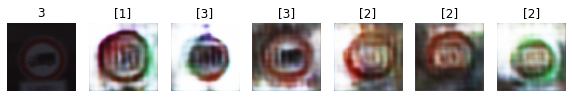

Epoch 20600 g_loss= 2.5583656 d_loss= 0.19191673 real_acc= 0.94 fake_acc= 0.98
Epoch 20700 g_loss= 2.3091629 d_loss= 0.23341289 real_acc= 0.88 fake_acc= 1.0
Epoch 20800 g_loss= 2.800383 d_loss= 0.20220178 real_acc= 0.92 fake_acc= 0.98
Epoch 20900 g_loss= 2.3786976 d_loss= 0.19206521 real_acc= 0.94 fake_acc= 0.96
Epoch 21000 g_loss= 2.9968688 d_loss= 0.29263198 real_acc= 0.78 fake_acc= 0.96


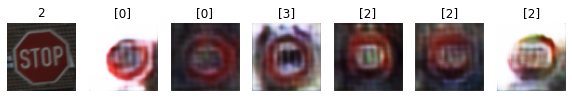

Epoch 21100 g_loss= 2.7302628 d_loss= 0.23466964 real_acc= 0.92 fake_acc= 1.0
Epoch 21200 g_loss= 2.3330178 d_loss= 0.22226444 real_acc= 0.94 fake_acc= 0.94
Epoch 21300 g_loss= 2.532804 d_loss= 0.1636577 real_acc= 0.98 fake_acc= 0.94
Epoch 21400 g_loss= 2.4256568 d_loss= 0.2122772 real_acc= 0.92 fake_acc= 1.0
Epoch 21500 g_loss= 2.0705836 d_loss= 0.24774712 real_acc= 0.92 fake_acc= 0.94


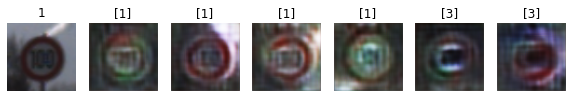

Epoch 21600 g_loss= 2.0773513 d_loss= 0.20586008 real_acc= 0.94 fake_acc= 0.98
Epoch 21700 g_loss= 1.9871713 d_loss= 0.23357838 real_acc= 0.92 fake_acc= 0.92
Epoch 21800 g_loss= 1.9704593 d_loss= 0.22061671 real_acc= 0.88 fake_acc= 0.96
Epoch 21900 g_loss= 2.9106076 d_loss= 0.19775182 real_acc= 0.88 fake_acc= 1.0
Epoch 22000 g_loss= 1.7711289 d_loss= 0.27413258 real_acc= 0.9 fake_acc= 0.86


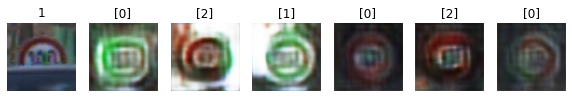

Epoch 22100 g_loss= 2.1153457 d_loss= 0.22244547 real_acc= 0.92 fake_acc= 0.94
Epoch 22200 g_loss= 2.5356524 d_loss= 0.2756335 real_acc= 0.88 fake_acc= 0.96
Epoch 22300 g_loss= 2.542828 d_loss= 0.2609345 real_acc= 0.82 fake_acc= 0.98
Epoch 22400 g_loss= 2.1497457 d_loss= 0.18104915 real_acc= 0.98 fake_acc= 0.98
Epoch 22500 g_loss= 2.435451 d_loss= 0.17652777 real_acc= 0.96 fake_acc= 0.94


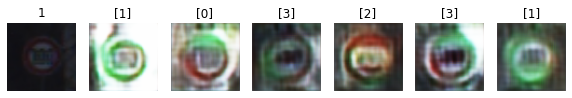

Epoch 22600 g_loss= 2.1907141 d_loss= 0.23076935 real_acc= 0.86 fake_acc= 0.94
Epoch 22700 g_loss= 2.1261156 d_loss= 0.25073445 real_acc= 0.86 fake_acc= 1.0
Epoch 22800 g_loss= 2.1122887 d_loss= 0.21665716 real_acc= 0.92 fake_acc= 0.92
Epoch 22900 g_loss= 2.3755388 d_loss= 0.21207792 real_acc= 0.86 fake_acc= 0.98
Epoch 23000 g_loss= 2.6907086 d_loss= 0.2328515 real_acc= 0.88 fake_acc= 0.92


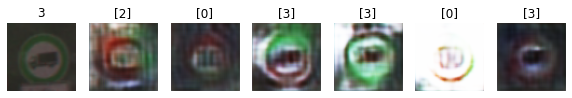

Epoch 23100 g_loss= 2.3840733 d_loss= 0.25902563 real_acc= 0.86 fake_acc= 0.98
Epoch 23200 g_loss= 2.3571486 d_loss= 0.19887313 real_acc= 0.92 fake_acc= 0.98
Epoch 23300 g_loss= 2.6165137 d_loss= 0.22059944 real_acc= 0.88 fake_acc= 0.98
Epoch 23400 g_loss= 2.667735 d_loss= 0.23809013 real_acc= 0.88 fake_acc= 0.98
Epoch 23500 g_loss= 2.5195916 d_loss= 0.22278342 real_acc= 0.88 fake_acc= 0.94


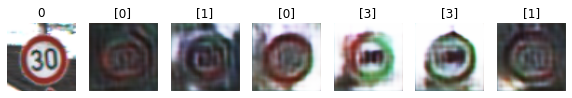

Epoch 23600 g_loss= 2.341964 d_loss= 0.26538622 real_acc= 0.84 fake_acc= 0.9
Epoch 23700 g_loss= 2.5420458 d_loss= 0.18891546 real_acc= 0.9 fake_acc= 1.0
Epoch 23800 g_loss= 2.4380465 d_loss= 0.2154814 real_acc= 0.88 fake_acc= 0.94
Epoch 23900 g_loss= 2.6262658 d_loss= 0.17319559 real_acc= 0.94 fake_acc= 0.98
Epoch 24000 g_loss= 2.2441769 d_loss= 0.21051855 real_acc= 0.9 fake_acc= 0.92


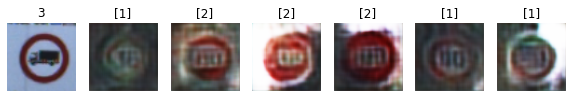

Epoch 24100 g_loss= 1.9481944 d_loss= 0.22687706 real_acc= 0.96 fake_acc= 0.88
Epoch 24200 g_loss= 2.169656 d_loss= 0.18174377 real_acc= 0.96 fake_acc= 0.94
Epoch 24300 g_loss= 2.1629717 d_loss= 0.22894654 real_acc= 0.92 fake_acc= 0.94
Epoch 24400 g_loss= 2.5407863 d_loss= 0.24595001 real_acc= 0.88 fake_acc= 0.96
Epoch 24500 g_loss= 2.5855758 d_loss= 0.23150906 real_acc= 0.84 fake_acc= 1.0


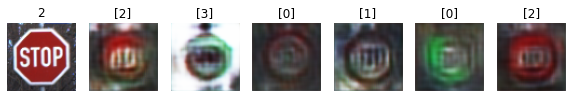

Epoch 24600 g_loss= 2.1682687 d_loss= 0.27316833 real_acc= 0.86 fake_acc= 0.92
Epoch 24700 g_loss= 2.5109022 d_loss= 0.21887761 real_acc= 0.86 fake_acc= 1.0
Epoch 24800 g_loss= 2.5832312 d_loss= 0.19708574 real_acc= 0.92 fake_acc= 1.0
Epoch 24900 g_loss= 2.1688802 d_loss= 0.23231608 real_acc= 0.94 fake_acc= 0.9
Epoch 25000 g_loss= 2.1699667 d_loss= 0.22241203 real_acc= 0.86 fake_acc= 0.94


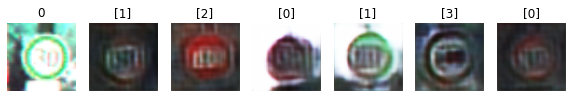

Epoch 25100 g_loss= 2.1141524 d_loss= 0.20396836 real_acc= 0.94 fake_acc= 0.94
Epoch 25200 g_loss= 2.5479424 d_loss= 0.1836228 real_acc= 0.92 fake_acc= 0.98
Epoch 25300 g_loss= 2.341275 d_loss= 0.22737956 real_acc= 0.9 fake_acc= 0.98
Epoch 25400 g_loss= 2.013991 d_loss= 0.21842995 real_acc= 0.9 fake_acc= 0.92
Epoch 25500 g_loss= 2.6150491 d_loss= 0.27607295 real_acc= 0.86 fake_acc= 0.96


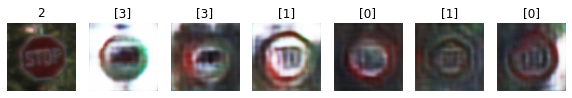

Epoch 25600 g_loss= 2.4879572 d_loss= 0.27531272 real_acc= 0.84 fake_acc= 0.94
Epoch 25700 g_loss= 2.529245 d_loss= 0.20092753 real_acc= 0.9 fake_acc= 0.96
Epoch 25800 g_loss= 2.849679 d_loss= 0.2453537 real_acc= 0.8 fake_acc= 1.0
Epoch 25900 g_loss= 2.3465478 d_loss= 0.19437999 real_acc= 0.94 fake_acc= 0.98
Epoch 26000 g_loss= 2.4119806 d_loss= 0.23815823 real_acc= 0.9 fake_acc= 0.96


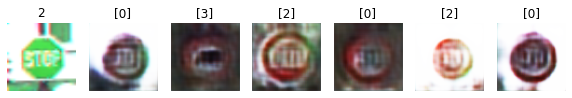

Epoch 26100 g_loss= 2.5979218 d_loss= 0.20118377 real_acc= 0.84 fake_acc= 0.94
Epoch 26200 g_loss= 2.2152452 d_loss= 0.24823478 real_acc= 0.9 fake_acc= 0.96
Epoch 26300 g_loss= 2.2355087 d_loss= 0.22109061 real_acc= 0.92 fake_acc= 1.0
Epoch 26400 g_loss= 2.334498 d_loss= 0.29355884 real_acc= 0.88 fake_acc= 0.96
Epoch 26500 g_loss= 1.9619226 d_loss= 0.19823489 real_acc= 0.94 fake_acc= 0.98


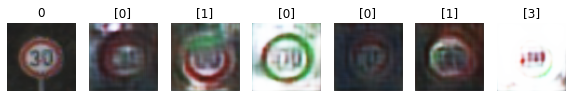

Epoch 26600 g_loss= 2.5809393 d_loss= 0.23714718 real_acc= 0.86 fake_acc= 1.0
Epoch 26700 g_loss= 2.6676843 d_loss= 0.24343315 real_acc= 0.86 fake_acc= 0.98
Epoch 26800 g_loss= 1.7333537 d_loss= 0.23967692 real_acc= 0.92 fake_acc= 0.92
Epoch 26900 g_loss= 2.1372027 d_loss= 0.23952258 real_acc= 0.9 fake_acc= 0.9
Epoch 27000 g_loss= 2.1207497 d_loss= 0.17625484 real_acc= 0.96 fake_acc= 0.94


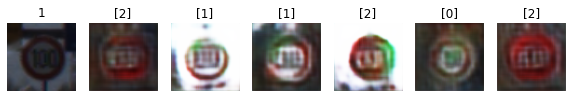

Epoch 27100 g_loss= 1.9455069 d_loss= 0.24457699 real_acc= 0.96 fake_acc= 0.9
Epoch 27200 g_loss= 2.1374247 d_loss= 0.19970824 real_acc= 0.9 fake_acc= 0.96
Epoch 27300 g_loss= 1.8527236 d_loss= 0.25412276 real_acc= 0.94 fake_acc= 0.9
Epoch 27400 g_loss= 2.069496 d_loss= 0.2005061 real_acc= 0.9 fake_acc= 0.98
Epoch 27500 g_loss= 2.227987 d_loss= 0.2389088 real_acc= 0.84 fake_acc= 0.94


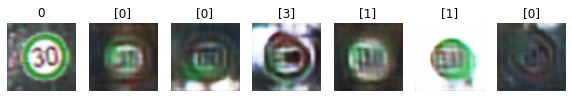

Epoch 27600 g_loss= 2.4486046 d_loss= 0.199417 real_acc= 0.92 fake_acc= 0.94
Epoch 27700 g_loss= 2.5580618 d_loss= 0.29592335 real_acc= 0.82 fake_acc= 0.96
Epoch 27800 g_loss= 2.2796264 d_loss= 0.17596579 real_acc= 0.94 fake_acc= 0.96
Epoch 27900 g_loss= 2.4061549 d_loss= 0.15509066 real_acc= 0.96 fake_acc= 1.0
Epoch 28000 g_loss= 2.0071857 d_loss= 0.24983594 real_acc= 0.94 fake_acc= 0.9


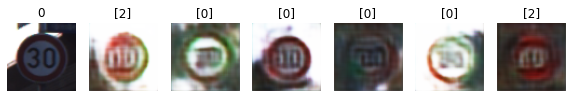

Epoch 28100 g_loss= 2.5132184 d_loss= 0.20700851 real_acc= 0.88 fake_acc= 0.98
Epoch 28200 g_loss= 2.1353605 d_loss= 0.24303523 real_acc= 0.92 fake_acc= 0.92
Epoch 28300 g_loss= 3.1039722 d_loss= 0.3307179 real_acc= 0.78 fake_acc= 0.94
Epoch 28400 g_loss= 3.1122663 d_loss= 0.23530085 real_acc= 0.82 fake_acc= 1.0
Epoch 28500 g_loss= 2.5939934 d_loss= 0.26250565 real_acc= 0.84 fake_acc= 0.96


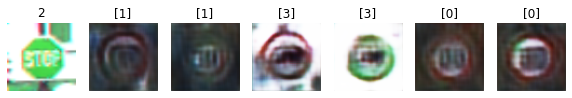

Epoch 28600 g_loss= 2.6296744 d_loss= 0.20312628 real_acc= 0.88 fake_acc= 1.0
Epoch 28700 g_loss= 2.014008 d_loss= 0.24774349 real_acc= 0.9 fake_acc= 0.9
Epoch 28800 g_loss= 2.3963854 d_loss= 0.21999717 real_acc= 0.92 fake_acc= 0.88
Epoch 28900 g_loss= 2.0744479 d_loss= 0.2166373 real_acc= 0.94 fake_acc= 0.92
Epoch 29000 g_loss= 2.5530834 d_loss= 0.24692637 real_acc= 0.86 fake_acc= 0.94


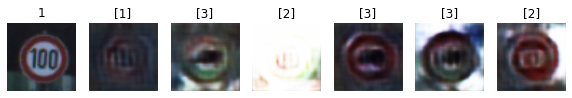

Epoch 29100 g_loss= 1.9253634 d_loss= 0.21269253 real_acc= 0.94 fake_acc= 0.92
Epoch 29200 g_loss= 2.4856427 d_loss= 0.22407037 real_acc= 0.86 fake_acc= 0.96
Epoch 29300 g_loss= 1.6314764 d_loss= 0.2941809 real_acc= 0.94 fake_acc= 0.88
Epoch 29400 g_loss= 2.743202 d_loss= 0.17717753 real_acc= 0.9 fake_acc= 0.98
Epoch 29500 g_loss= 2.2912138 d_loss= 0.16830301 real_acc= 0.96 fake_acc= 0.94


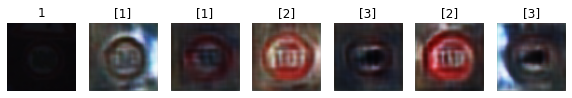

Epoch 29600 g_loss= 2.577315 d_loss= 0.25645542 real_acc= 0.92 fake_acc= 0.98
Epoch 29700 g_loss= 2.1504672 d_loss= 0.20652227 real_acc= 0.96 fake_acc= 0.9
Epoch 29800 g_loss= 1.6113062 d_loss= 0.3349734 real_acc= 0.88 fake_acc= 0.86
Epoch 29900 g_loss= 1.9369292 d_loss= 0.2434474 real_acc= 0.92 fake_acc= 0.96
Epoch 30000 g_loss= 2.6703339 d_loss= 0.21191481 real_acc= 0.88 fake_acc= 0.98


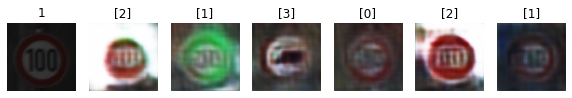

Epoch 30100 g_loss= 2.3879147 d_loss= 0.23585506 real_acc= 0.88 fake_acc= 1.0
Epoch 30200 g_loss= 2.1808295 d_loss= 0.27048936 real_acc= 0.88 fake_acc= 0.9
Epoch 30300 g_loss= 1.9098145 d_loss= 0.22643256 real_acc= 0.96 fake_acc= 0.94
Epoch 30400 g_loss= 2.4234383 d_loss= 0.1528204 real_acc= 0.94 fake_acc= 1.0
Epoch 30500 g_loss= 2.1373377 d_loss= 0.21667945 real_acc= 0.92 fake_acc= 0.96


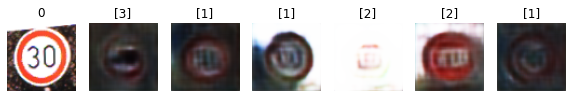

Epoch 30600 g_loss= 2.2123885 d_loss= 0.18687049 real_acc= 0.96 fake_acc= 0.92
Epoch 30700 g_loss= 2.644259 d_loss= 0.24473181 real_acc= 0.86 fake_acc= 1.0
Epoch 30800 g_loss= 2.2948196 d_loss= 0.19809152 real_acc= 0.92 fake_acc= 0.96
Epoch 30900 g_loss= 2.9271111 d_loss= 0.24155241 real_acc= 0.88 fake_acc= 1.0
Epoch 31000 g_loss= 2.5199115 d_loss= 0.20752463 real_acc= 0.94 fake_acc= 0.96


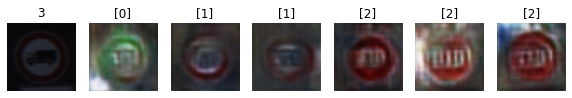

Epoch 31100 g_loss= 1.907025 d_loss= 0.24615945 real_acc= 0.96 fake_acc= 0.86
Epoch 31200 g_loss= 2.1749504 d_loss= 0.21434486 real_acc= 0.94 fake_acc= 0.94
Epoch 31300 g_loss= 2.2968347 d_loss= 0.19627221 real_acc= 0.94 fake_acc= 0.9
Epoch 31400 g_loss= 2.6600559 d_loss= 0.16409865 real_acc= 0.94 fake_acc= 0.96
Epoch 31500 g_loss= 2.2854345 d_loss= 0.20819594 real_acc= 0.9 fake_acc= 0.96


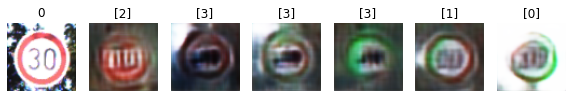

Epoch 31600 g_loss= 2.6593804 d_loss= 0.19105378 real_acc= 0.9 fake_acc= 1.0
Epoch 31700 g_loss= 2.3360007 d_loss= 0.2006605 real_acc= 0.94 fake_acc= 0.96
Epoch 31800 g_loss= 2.674699 d_loss= 0.17176911 real_acc= 0.94 fake_acc= 0.92
Epoch 31900 g_loss= 2.433534 d_loss= 0.18840979 real_acc= 0.88 fake_acc= 0.98
Epoch 32000 g_loss= 2.3544636 d_loss= 0.1885162 real_acc= 0.9 fake_acc= 0.96


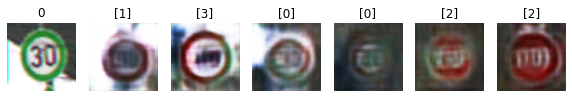

Epoch 32100 g_loss= 2.6358786 d_loss= 0.21298374 real_acc= 0.86 fake_acc= 0.98
Epoch 32200 g_loss= 2.2996378 d_loss= 0.16740552 real_acc= 0.96 fake_acc= 0.94
Epoch 32300 g_loss= 3.0471542 d_loss= 0.23822342 real_acc= 0.88 fake_acc= 0.98
Epoch 32400 g_loss= 2.0828173 d_loss= 0.20927103 real_acc= 0.96 fake_acc= 0.92
Epoch 32500 g_loss= 2.5139208 d_loss= 0.18996695 real_acc= 0.88 fake_acc= 0.98


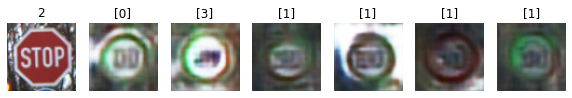

Epoch 32600 g_loss= 2.789664 d_loss= 0.23488586 real_acc= 0.82 fake_acc= 0.96
Epoch 32700 g_loss= 2.2056718 d_loss= 0.19070686 real_acc= 0.98 fake_acc= 0.94
Epoch 32800 g_loss= 2.2356281 d_loss= 0.16221145 real_acc= 0.96 fake_acc= 0.98
Epoch 32900 g_loss= 1.7921864 d_loss= 0.27828255 real_acc= 0.94 fake_acc= 0.84
Epoch 33000 g_loss= 2.5922732 d_loss= 0.16793147 real_acc= 0.96 fake_acc= 0.98


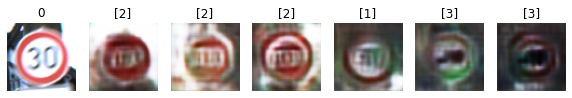

Epoch 33100 g_loss= 2.134138 d_loss= 0.22537059 real_acc= 0.92 fake_acc= 0.94
Epoch 33200 g_loss= 2.4997082 d_loss= 0.18245545 real_acc= 0.94 fake_acc= 0.94
Epoch 33300 g_loss= 2.1999724 d_loss= 0.20738247 real_acc= 0.92 fake_acc= 0.94
Epoch 33400 g_loss= 2.2506745 d_loss= 0.21905948 real_acc= 0.92 fake_acc= 0.94
Epoch 33500 g_loss= 2.0745378 d_loss= 0.23375636 real_acc= 0.94 fake_acc= 0.92


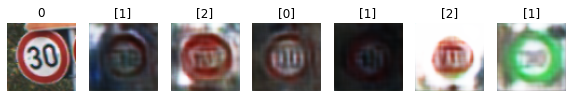

Epoch 33600 g_loss= 2.7431846 d_loss= 0.24740154 real_acc= 0.86 fake_acc= 1.0
Epoch 33700 g_loss= 2.8582745 d_loss= 0.2659193 real_acc= 0.84 fake_acc= 0.98
Epoch 33800 g_loss= 2.5715868 d_loss= 0.2343685 real_acc= 0.9 fake_acc= 0.98
Epoch 33900 g_loss= 2.2195458 d_loss= 0.20418534 real_acc= 0.96 fake_acc= 0.92
Epoch 34000 g_loss= 2.0957036 d_loss= 0.19813028 real_acc= 0.98 fake_acc= 0.92


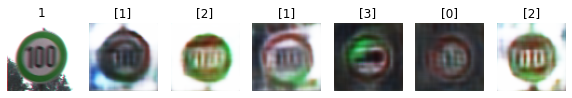

Epoch 34100 g_loss= 2.0295591 d_loss= 0.23208459 real_acc= 0.96 fake_acc= 0.94
Epoch 34200 g_loss= 1.7757627 d_loss= 0.31149012 real_acc= 0.92 fake_acc= 0.86
Epoch 34300 g_loss= 3.0255563 d_loss= 0.18735433 real_acc= 0.92 fake_acc= 1.0
Epoch 34400 g_loss= 1.9950027 d_loss= 0.25977632 real_acc= 0.88 fake_acc= 0.88
Epoch 34500 g_loss= 2.7991285 d_loss= 0.26865464 real_acc= 0.82 fake_acc= 0.98


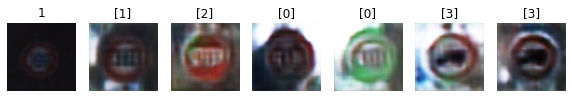

Epoch 34600 g_loss= 2.3378947 d_loss= 0.20124777 real_acc= 0.96 fake_acc= 0.96
Epoch 34700 g_loss= 2.6038938 d_loss= 0.2196823 real_acc= 0.92 fake_acc= 0.98
Epoch 34800 g_loss= 2.0474029 d_loss= 0.2239179 real_acc= 0.96 fake_acc= 0.88
Epoch 34900 g_loss= 2.490505 d_loss= 0.20079061 real_acc= 0.94 fake_acc= 0.98
Epoch 35000 g_loss= 2.3649056 d_loss= 0.23372957 real_acc= 0.88 fake_acc= 0.94


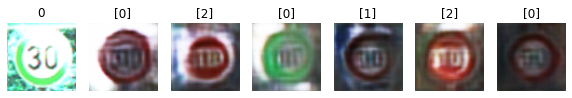

Epoch 35100 g_loss= 2.8361902 d_loss= 0.21828368 real_acc= 0.88 fake_acc= 1.0
Epoch 35200 g_loss= 2.619483 d_loss= 0.20994428 real_acc= 0.9 fake_acc= 0.98
Epoch 35300 g_loss= 2.6134675 d_loss= 0.17436236 real_acc= 0.9 fake_acc= 0.98
Epoch 35400 g_loss= 2.2645535 d_loss= 0.1926015 real_acc= 0.96 fake_acc= 0.9
Epoch 35500 g_loss= 1.7930413 d_loss= 0.23704433 real_acc= 0.94 fake_acc= 0.84


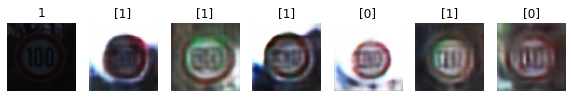

Epoch 35600 g_loss= 2.65441 d_loss= 0.27419153 real_acc= 0.88 fake_acc= 0.9
Epoch 35700 g_loss= 1.8700528 d_loss= 0.2244046 real_acc= 0.96 fake_acc= 0.94
Epoch 35800 g_loss= 2.8896441 d_loss= 0.17619407 real_acc= 0.88 fake_acc= 0.98
Epoch 35900 g_loss= 2.344584 d_loss= 0.23420428 real_acc= 0.94 fake_acc= 0.94
Epoch 36000 g_loss= 2.5527701 d_loss= 0.17270413 real_acc= 0.98 fake_acc= 0.94


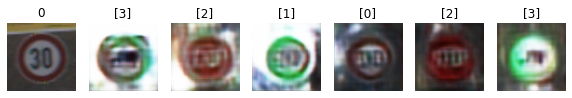

Epoch 36100 g_loss= 2.1460676 d_loss= 0.23946068 real_acc= 0.92 fake_acc= 0.9
Epoch 36200 g_loss= 2.3702765 d_loss= 0.18349633 real_acc= 0.92 fake_acc= 0.98
Epoch 36300 g_loss= 2.076922 d_loss= 0.21729234 real_acc= 0.96 fake_acc= 0.84
Epoch 36400 g_loss= 1.8470575 d_loss= 0.22962469 real_acc= 0.94 fake_acc= 0.84
Epoch 36500 g_loss= 2.800957 d_loss= 0.23029017 real_acc= 0.88 fake_acc= 0.92


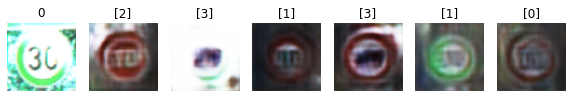

Epoch 36600 g_loss= 2.299439 d_loss= 0.20176464 real_acc= 0.94 fake_acc= 0.92
Epoch 36700 g_loss= 1.9532928 d_loss= 0.22504558 real_acc= 0.92 fake_acc= 0.92
Epoch 36800 g_loss= 2.6991227 d_loss= 0.19338843 real_acc= 0.88 fake_acc= 0.98
Epoch 36900 g_loss= 2.6208518 d_loss= 0.2370352 real_acc= 0.9 fake_acc= 0.94
Epoch 37000 g_loss= 2.181909 d_loss= 0.20347168 real_acc= 0.96 fake_acc= 0.92


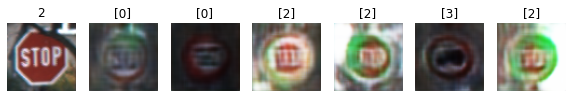

Epoch 37100 g_loss= 2.8997257 d_loss= 0.16900732 real_acc= 0.9 fake_acc= 0.98
Epoch 37200 g_loss= 2.2047503 d_loss= 0.23811588 real_acc= 0.92 fake_acc= 0.9
Epoch 37300 g_loss= 2.2396252 d_loss= 0.20288396 real_acc= 0.94 fake_acc= 0.92
Epoch 37400 g_loss= 2.6258907 d_loss= 0.21568003 real_acc= 0.88 fake_acc= 0.94
Epoch 37500 g_loss= 2.3636756 d_loss= 0.22116795 real_acc= 0.92 fake_acc= 0.92


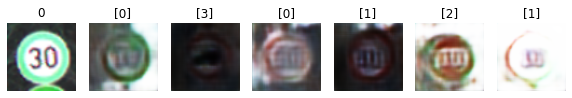

Epoch 37600 g_loss= 2.456378 d_loss= 0.21322533 real_acc= 0.88 fake_acc= 0.98
Epoch 37700 g_loss= 3.2820535 d_loss= 0.2259984 real_acc= 0.82 fake_acc= 1.0
Epoch 37800 g_loss= 2.7468798 d_loss= 0.18095648 real_acc= 0.9 fake_acc= 0.96
Epoch 37900 g_loss= 2.4426994 d_loss= 0.22478545 real_acc= 0.92 fake_acc= 0.94
Epoch 38000 g_loss= 2.1914072 d_loss= 0.24451613 real_acc= 0.88 fake_acc= 0.94


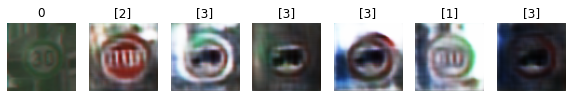

Epoch 38100 g_loss= 2.213358 d_loss= 0.1843126 real_acc= 0.98 fake_acc= 0.98
Epoch 38200 g_loss= 2.5847967 d_loss= 0.16555463 real_acc= 0.92 fake_acc= 1.0
Epoch 38300 g_loss= 2.6583273 d_loss= 0.29882318 real_acc= 0.84 fake_acc= 0.92
Epoch 38400 g_loss= 2.5362158 d_loss= 0.18382101 real_acc= 0.9 fake_acc= 0.96
Epoch 38500 g_loss= 2.7096472 d_loss= 0.17434882 real_acc= 0.92 fake_acc= 1.0


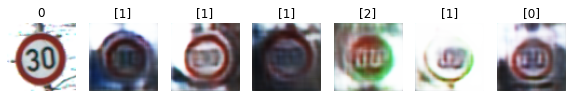

Epoch 38600 g_loss= 2.7661216 d_loss= 0.23089026 real_acc= 0.84 fake_acc= 1.0
Epoch 38700 g_loss= 2.0525784 d_loss= 0.22249061 real_acc= 0.92 fake_acc= 0.88
Epoch 38800 g_loss= 2.780329 d_loss= 0.1767821 real_acc= 0.96 fake_acc= 0.96
Epoch 38900 g_loss= 1.7703778 d_loss= 0.22890256 real_acc= 0.92 fake_acc= 0.9
Epoch 39000 g_loss= 2.5438154 d_loss= 0.20823753 real_acc= 0.9 fake_acc= 0.98


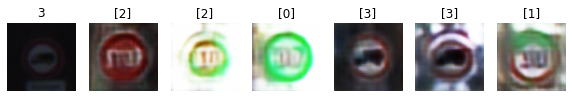

Epoch 39100 g_loss= 2.2206888 d_loss= 0.19576071 real_acc= 0.92 fake_acc= 0.96
Epoch 39200 g_loss= 2.3678198 d_loss= 0.27729696 real_acc= 0.84 fake_acc= 0.92
Epoch 39300 g_loss= 2.492879 d_loss= 0.18758714 real_acc= 0.94 fake_acc= 0.94
Epoch 39400 g_loss= 3.1593518 d_loss= 0.17600909 real_acc= 0.96 fake_acc= 0.98
Epoch 39500 g_loss= 2.460576 d_loss= 0.19237825 real_acc= 0.92 fake_acc= 0.94


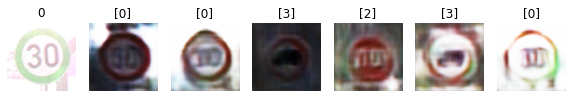

Epoch 39600 g_loss= 2.8694513 d_loss= 0.21480028 real_acc= 0.86 fake_acc= 0.96
Epoch 39700 g_loss= 2.2457125 d_loss= 0.17286795 real_acc= 1.0 fake_acc= 0.92
Epoch 39800 g_loss= 2.3661983 d_loss= 0.22271128 real_acc= 0.96 fake_acc= 0.96
Epoch 39900 g_loss= 2.629611 d_loss= 0.18639755 real_acc= 0.94 fake_acc= 0.94
Epoch 40000 g_loss= 1.9246967 d_loss= 0.23958462 real_acc= 0.94 fake_acc= 0.92


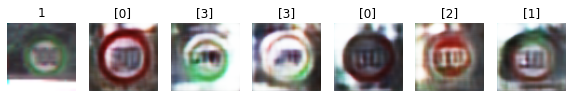

Epoch 40100 g_loss= 3.1306689 d_loss= 0.21845388 real_acc= 0.88 fake_acc= 0.96
Epoch 40200 g_loss= 3.3719184 d_loss= 0.24779218 real_acc= 0.8 fake_acc= 0.98
Epoch 40300 g_loss= 2.6299088 d_loss= 0.17344849 real_acc= 0.92 fake_acc= 0.98
Epoch 40400 g_loss= 2.8176758 d_loss= 0.2171188 real_acc= 0.86 fake_acc= 0.98
Epoch 40500 g_loss= 2.2056758 d_loss= 0.24125579 real_acc= 0.92 fake_acc= 0.96


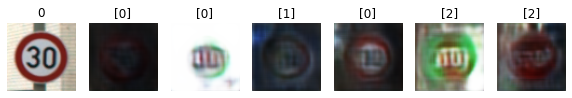

Epoch 40600 g_loss= 2.5764441 d_loss= 0.16737573 real_acc= 0.92 fake_acc= 0.96
Epoch 40700 g_loss= 2.1699572 d_loss= 0.19165689 real_acc= 0.94 fake_acc= 0.98
Epoch 40800 g_loss= 2.003774 d_loss= 0.2575664 real_acc= 0.88 fake_acc= 0.9
Epoch 40900 g_loss= 2.5675216 d_loss= 0.21718767 real_acc= 0.9 fake_acc= 0.94
Epoch 41000 g_loss= 2.0365164 d_loss= 0.24521211 real_acc= 0.92 fake_acc= 0.88


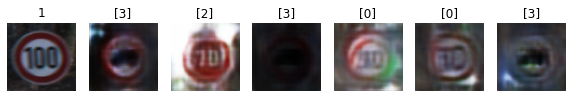

Epoch 41100 g_loss= 2.7025645 d_loss= 0.22186664 real_acc= 0.86 fake_acc= 0.96
Epoch 41200 g_loss= 2.5187006 d_loss= 0.1500546 real_acc= 0.96 fake_acc= 1.0
Epoch 41300 g_loss= 2.9194455 d_loss= 0.18464997 real_acc= 0.92 fake_acc= 0.98
Epoch 41400 g_loss= 2.1940753 d_loss= 0.2518125 real_acc= 0.86 fake_acc= 0.94
Epoch 41500 g_loss= 2.1892965 d_loss= 0.23205085 real_acc= 0.92 fake_acc= 0.96


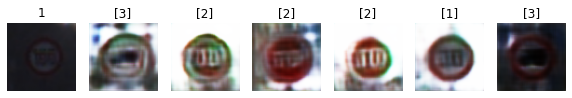

Epoch 41600 g_loss= 2.3756754 d_loss= 0.20332521 real_acc= 0.9 fake_acc= 0.96
Epoch 41700 g_loss= 2.7075477 d_loss= 0.24073352 real_acc= 0.84 fake_acc= 1.0
Epoch 41800 g_loss= 3.453935 d_loss= 0.18550684 real_acc= 0.88 fake_acc= 1.0
Epoch 41900 g_loss= 2.324042 d_loss= 0.15860088 real_acc= 0.98 fake_acc= 0.96
Epoch 42000 g_loss= 2.5960495 d_loss= 0.18259406 real_acc= 0.92 fake_acc= 0.92


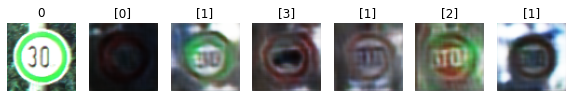

Epoch 42100 g_loss= 2.5478885 d_loss= 0.20059076 real_acc= 0.92 fake_acc= 0.94
Epoch 42200 g_loss= 3.2063186 d_loss= 0.17754602 real_acc= 0.92 fake_acc= 0.98
Epoch 42300 g_loss= 2.0053687 d_loss= 0.18934712 real_acc= 0.98 fake_acc= 0.92
Epoch 42400 g_loss= 2.5678763 d_loss= 0.1881813 real_acc= 0.94 fake_acc= 1.0
Epoch 42500 g_loss= 2.7700808 d_loss= 0.17028183 real_acc= 0.92 fake_acc= 0.98


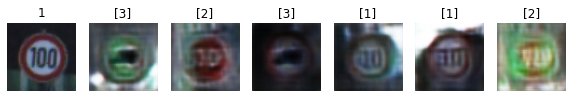

Epoch 42600 g_loss= 3.1501136 d_loss= 0.24260122 real_acc= 0.82 fake_acc= 1.0
Epoch 42700 g_loss= 2.509834 d_loss= 0.21452758 real_acc= 0.92 fake_acc= 0.96
Epoch 42800 g_loss= 2.2257283 d_loss= 0.22991866 real_acc= 0.88 fake_acc= 0.94
Epoch 42900 g_loss= 2.541683 d_loss= 0.18661386 real_acc= 0.94 fake_acc= 0.92
Epoch 43000 g_loss= 2.2641916 d_loss= 0.25101632 real_acc= 0.88 fake_acc= 0.96


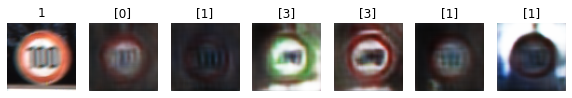

Epoch 43100 g_loss= 2.8227234 d_loss= 0.17433994 real_acc= 0.92 fake_acc= 0.98
Epoch 43200 g_loss= 2.317895 d_loss= 0.19733793 real_acc= 0.96 fake_acc= 0.94
Epoch 43300 g_loss= 2.7547593 d_loss= 0.15997604 real_acc= 0.92 fake_acc= 1.0
Epoch 43400 g_loss= 2.20651 d_loss= 0.16807786 real_acc= 0.98 fake_acc= 0.98
Epoch 43500 g_loss= 2.1843305 d_loss= 0.20602347 real_acc= 0.92 fake_acc= 0.94


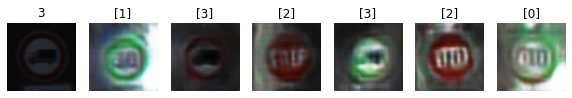

Epoch 43600 g_loss= 2.530395 d_loss= 0.23331514 real_acc= 0.88 fake_acc= 0.94
Epoch 43700 g_loss= 2.6169329 d_loss= 0.17538211 real_acc= 0.92 fake_acc= 0.98
Epoch 43800 g_loss= 3.145765 d_loss= 0.19786555 real_acc= 0.88 fake_acc= 1.0
Epoch 43900 g_loss= 2.7014265 d_loss= 0.20740084 real_acc= 0.9 fake_acc= 0.98
Epoch 44000 g_loss= 2.6407654 d_loss= 0.24292472 real_acc= 0.88 fake_acc= 0.94


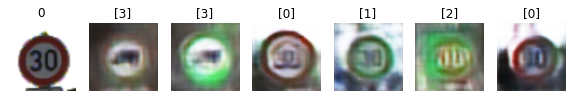

Epoch 44100 g_loss= 2.8906815 d_loss= 0.2737287 real_acc= 0.8 fake_acc= 0.96
Epoch 44200 g_loss= 3.0110168 d_loss= 0.18371937 real_acc= 0.86 fake_acc= 0.98
Epoch 44300 g_loss= 3.2984195 d_loss= 0.20066223 real_acc= 0.86 fake_acc= 1.0
Epoch 44400 g_loss= 2.4790678 d_loss= 0.17260635 real_acc= 0.96 fake_acc= 0.92
Epoch 44500 g_loss= 3.0917535 d_loss= 0.27183622 real_acc= 0.78 fake_acc= 1.0


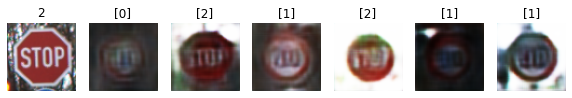

Epoch 44600 g_loss= 2.2355998 d_loss= 0.15973958 real_acc= 0.98 fake_acc= 0.94
Epoch 44700 g_loss= 2.6789918 d_loss= 0.18043017 real_acc= 0.92 fake_acc= 0.98
Epoch 44800 g_loss= 2.3247101 d_loss= 0.21955906 real_acc= 0.9 fake_acc= 0.9
Epoch 44900 g_loss= 2.816234 d_loss= 0.16722055 real_acc= 0.94 fake_acc= 1.0
Epoch 45000 g_loss= 2.6384208 d_loss= 0.12557717 real_acc= 0.98 fake_acc= 0.96


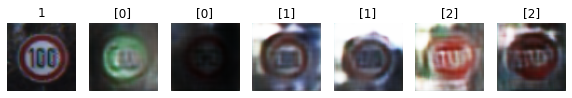

Epoch 45100 g_loss= 3.1340728 d_loss= 0.19262564 real_acc= 0.9 fake_acc= 0.98
Epoch 45200 g_loss= 2.330203 d_loss= 0.22944802 real_acc= 0.84 fake_acc= 0.96
Epoch 45300 g_loss= 2.748303 d_loss= 0.1343745 real_acc= 0.98 fake_acc= 0.98
Epoch 45400 g_loss= 3.3165128 d_loss= 0.2884765 real_acc= 0.78 fake_acc= 0.98
Epoch 45500 g_loss= 2.6562989 d_loss= 0.14995635 real_acc= 0.94 fake_acc= 0.96


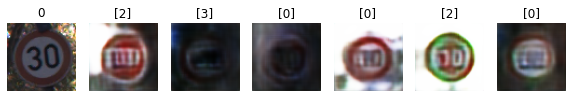

Epoch 45600 g_loss= 2.4183044 d_loss= 0.19602282 real_acc= 0.88 fake_acc= 0.98
Epoch 45700 g_loss= 2.7890408 d_loss= 0.20380113 real_acc= 0.9 fake_acc= 0.96
Epoch 45800 g_loss= 2.6478083 d_loss= 0.1841962 real_acc= 0.94 fake_acc= 0.98
Epoch 45900 g_loss= 2.4809341 d_loss= 0.1999022 real_acc= 0.94 fake_acc= 0.92
Epoch 46000 g_loss= 2.0172467 d_loss= 0.20867828 real_acc= 0.98 fake_acc= 0.86


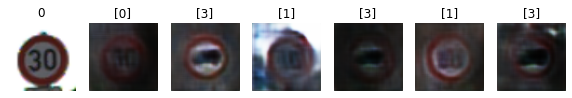

Epoch 46100 g_loss= 2.465929 d_loss= 0.16419315 real_acc= 0.96 fake_acc= 0.98
Epoch 46200 g_loss= 1.794883 d_loss= 0.21961999 real_acc= 0.96 fake_acc= 0.86
Epoch 46300 g_loss= 2.1786776 d_loss= 0.16011827 real_acc= 0.98 fake_acc= 0.92
Epoch 46400 g_loss= 3.1494312 d_loss= 0.19282703 real_acc= 0.88 fake_acc= 1.0
Epoch 46500 g_loss= 2.3672647 d_loss= 0.27658603 real_acc= 0.88 fake_acc= 0.94


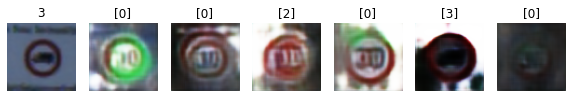

Epoch 46600 g_loss= 2.6107428 d_loss= 0.19346905 real_acc= 0.9 fake_acc= 0.98
Epoch 46700 g_loss= 2.4766037 d_loss= 0.24567467 real_acc= 0.9 fake_acc= 0.92
Epoch 46800 g_loss= 2.0237825 d_loss= 0.19459385 real_acc= 0.96 fake_acc= 0.96
Epoch 46900 g_loss= 2.2228608 d_loss= 0.2324473 real_acc= 0.9 fake_acc= 0.9
Epoch 47000 g_loss= 2.2236252 d_loss= 0.1752105 real_acc= 0.94 fake_acc= 0.98


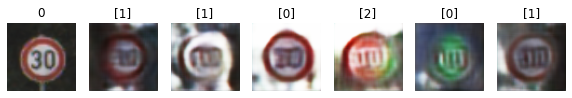

Epoch 47100 g_loss= 2.640651 d_loss= 0.22805676 real_acc= 0.88 fake_acc= 0.98
Epoch 47200 g_loss= 1.9671348 d_loss= 0.2189246 real_acc= 0.98 fake_acc= 0.88
Epoch 47300 g_loss= 2.731331 d_loss= 0.16610867 real_acc= 0.9 fake_acc= 1.0
Epoch 47400 g_loss= 3.3896983 d_loss= 0.1902136 real_acc= 0.9 fake_acc= 0.98
Epoch 47500 g_loss= 2.4782903 d_loss= 0.20649879 real_acc= 0.9 fake_acc= 0.96


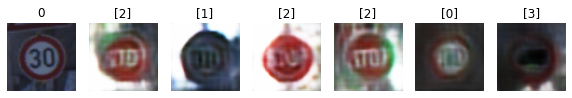

Epoch 47600 g_loss= 2.443356 d_loss= 0.13746068 real_acc= 0.96 fake_acc= 0.98
Epoch 47700 g_loss= 2.6141365 d_loss= 0.16213146 real_acc= 0.92 fake_acc= 1.0
Epoch 47800 g_loss= 2.8553677 d_loss= 0.20224863 real_acc= 0.9 fake_acc= 0.96
Epoch 47900 g_loss= 2.3022492 d_loss= 0.17558335 real_acc= 0.96 fake_acc= 0.98
Epoch 48000 g_loss= 2.3058271 d_loss= 0.18726632 real_acc= 0.94 fake_acc= 0.96


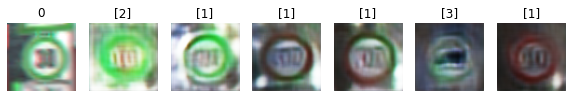

Epoch 48100 g_loss= 2.4557917 d_loss= 0.2023893 real_acc= 0.92 fake_acc= 0.94
Epoch 48200 g_loss= 2.7311335 d_loss= 0.19782743 real_acc= 0.92 fake_acc= 0.96
Epoch 48300 g_loss= 3.1860228 d_loss= 0.21492586 real_acc= 0.86 fake_acc= 0.96
Epoch 48400 g_loss= 1.8855284 d_loss= 0.22497383 real_acc= 0.92 fake_acc= 0.88
Epoch 48500 g_loss= 2.4314246 d_loss= 0.17219307 real_acc= 1.0 fake_acc= 0.96


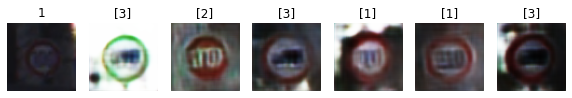

Epoch 48600 g_loss= 2.023869 d_loss= 0.16678673 real_acc= 0.98 fake_acc= 0.94
Epoch 48700 g_loss= 2.459589 d_loss= 0.20262119 real_acc= 0.92 fake_acc= 0.92
Epoch 48800 g_loss= 2.4770129 d_loss= 0.17026655 real_acc= 0.98 fake_acc= 1.0
Epoch 48900 g_loss= 2.1756535 d_loss= 0.18348093 real_acc= 0.98 fake_acc= 0.94
Epoch 49000 g_loss= 2.6247408 d_loss= 0.17312032 real_acc= 0.94 fake_acc= 0.98


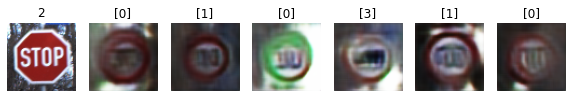

Epoch 49100 g_loss= 2.1451554 d_loss= 0.16086674 real_acc= 1.0 fake_acc= 0.9
Epoch 49200 g_loss= 2.401442 d_loss= 0.18997751 real_acc= 0.9 fake_acc= 0.98
Epoch 49300 g_loss= 2.868562 d_loss= 0.16403663 real_acc= 0.94 fake_acc= 1.0
Epoch 49400 g_loss= 2.6743708 d_loss= 0.19974121 real_acc= 0.84 fake_acc= 0.98
Epoch 49500 g_loss= 2.7081804 d_loss= 0.15506294 real_acc= 0.98 fake_acc= 0.96


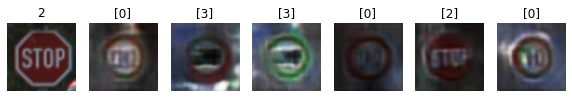

Epoch 49600 g_loss= 2.489295 d_loss= 0.1812557 real_acc= 0.98 fake_acc= 0.94
Epoch 49700 g_loss= 2.4108994 d_loss= 0.20417875 real_acc= 0.92 fake_acc= 0.96
Epoch 49800 g_loss= 3.1052814 d_loss= 0.24536644 real_acc= 0.84 fake_acc= 0.98
Epoch 49900 g_loss= 2.878406 d_loss= 0.22522426 real_acc= 0.88 fake_acc= 1.0
Done


In [11]:
epochs = 50000
for epoch in range(epochs):
    # take some random samples
    new_samples,new_labels = sample_from_dataset(50,samples)
    #print(new_samples.shape)
    # perform one training step (epoch)
    do_step(new_samples, new_labels)
    
    if epoch % 500 == 0:
        # show one real image and some fake images generated by generator using noise seed
        #display.clear_output(wait=True)
        num_examples_to_generate = 6
        seed = tf.random.normal([num_examples_to_generate, noise_dim])
        random_labels = np.random.randint(4, size=num_examples_to_generate)
        random_labels = np.expand_dims(random_labels,axis=1)
        predictions = generator([seed,random_labels], training=False)
        fig = plt.figure(figsize=(10,10))
        r = random.randrange(len(samples))
        plt.subplot(1, num_examples_to_generate+1, 1)
        plt.imshow(samples[r, :, :, :])
        plt.title(labels[r])
        plt.axis('off')
        for i in range(predictions.shape[0]):
            plt.subplot(1, num_examples_to_generate+1, i+2)
            #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.imshow(predictions[i, :, :, :])
            plt.title("{}".format(random_labels[i]))
            plt.axis('off')
        plt.show()    
    if epoch % 5000 == 0:
        generator.save('generator_color_{}.h5'.format(epoch))
        
print("Done")

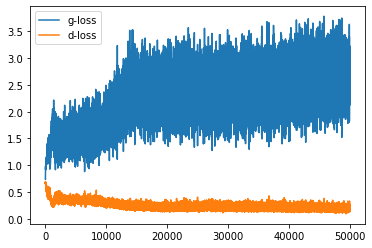

In [20]:
nph = np.array(history)

plt.plot(nph[:,0], label='g-loss')
plt.plot(nph[:,1], label='d-loss')
#plt.ylim([0,2])
plt.legend()
plt.show()

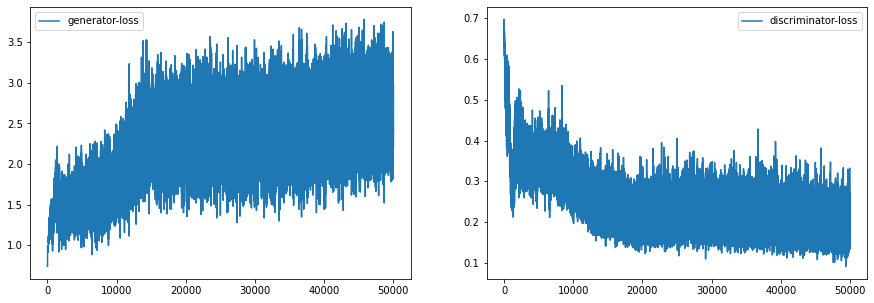

In [21]:
nph = np.array(history)
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
#plt.ylim([0,2])
plt.plot(nph[:,0], label='generator-loss')
plt.legend()
ax = plt.subplot(1, 2, 2)
plt.plot(nph[:,1], label='discriminator-loss')
#plt.ylim([0,2])
plt.legend()
plt.show()

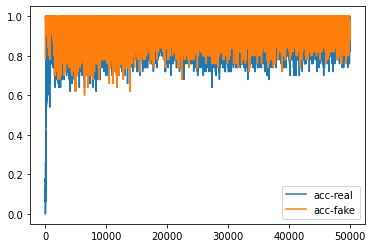

In [14]:
nph = np.array(history)

plt.plot(nph[:,2], label='acc-real')
plt.plot(nph[:,3], label='acc-fake')
plt.legend()
plt.show()

In [15]:
generator.save_weights('generator_color_4c_80k_weights.h5')

In [22]:
generator.save('generator_color_4c_80k.h5')

In [17]:
discriminator.save_weights('discriminator_color_4c_80k_weights.h5')

In [18]:
discriminator.save('discriminator_color_4c_80k.h5')

(36, 100)
(36, 1)


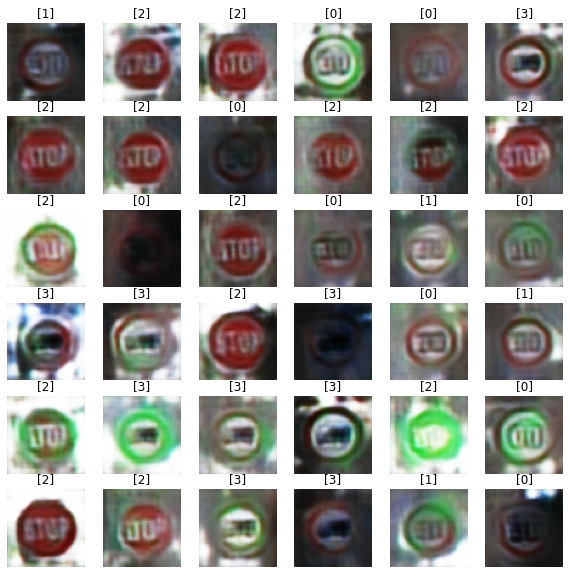

In [19]:
noise_dim = 100
num_examples_to_generate = 36
seed = tf.random.normal([num_examples_to_generate, noise_dim])
random_labels = np.random.randint(4, size=num_examples_to_generate)
random_labels = np.expand_dims(random_labels,axis=1)

print(seed.shape)
print(random_labels.shape)
predictions = generator([seed,random_labels])
fig = plt.figure(figsize=(10,10))
# r = random.randrange(len(samples))
# plt.subplot(1, num_examples_to_generate+1, 1)
#plt.imshow(samples[r, :, :, 0] * 127.5 + 127.5, cmap='gray')
#plt.axis('off')
for i in range(predictions.shape[0]):
    plt.subplot(6, 6, i+1)
    #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.imshow(predictions[i, :, :, :])
    plt.title("{}".format(random_labels[i]))
    plt.axis('off')
plt.show()    